m=1, z*=-1+0j, max_residual=6.667e-01
m=2, z*=1+0j, max_residual=2.220e-16
m=3, z*=-0.3333+0j, max_residual=1.110e-16

Final m=3, max test error=2.887e-15


C:\Users\jack9\AppData\Local\Temp\ipykernel_692\1734812506.py:47: RuntimeWarning: divide by zero encountered in divide
  Den = np.sum(w / (z_eval[..., None] - z[None, :]), axis=-1)
C:\Users\jack9\AppData\Local\Temp\ipykernel_692\1734812506.py:47: RuntimeWarning: invalid value encountered in divide
  Den = np.sum(w / (z_eval[..., None] - z[None, :]), axis=-1)
C:\Users\jack9\AppData\Local\Temp\ipykernel_692\1734812506.py:48: RuntimeWarning: divide by zero encountered in divide
  Num = np.sum((w * fz) / (z_eval[..., None] - z[None, :]), axis=-1)
C:\Users\jack9\AppData\Local\Temp\ipykernel_692\1734812506.py:48: RuntimeWarning: invalid value encountered in divide
  Num = np.sum((w * fz) / (z_eval[..., None] - z[None, :]), axis=-1)
C:\Users\jack9\AppData\Local\Temp\ipykernel_692\1734812506.py:49: RuntimeWarning: invalid value encountered in divide
  out = Num / Den


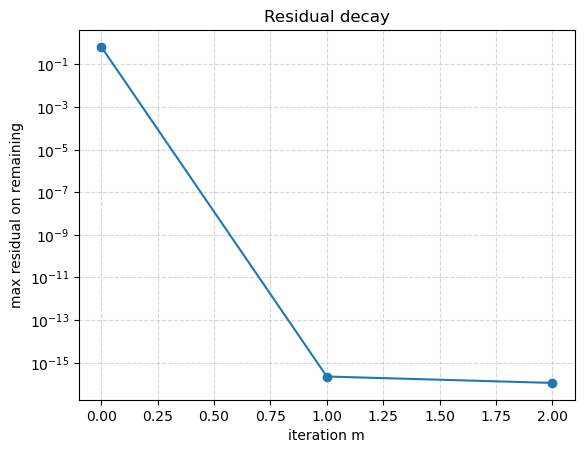

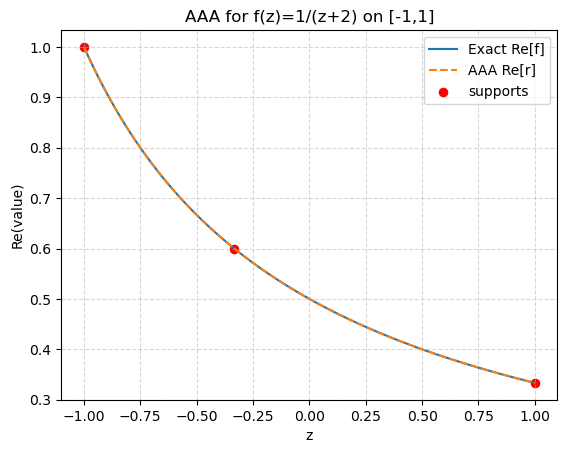

In [7]:
import numpy as np
import matplotlib.pyplot as plt
try:
    from scipy.linalg import svd
except Exception:
    from numpy.linalg import svd

# f, samples, target m
def f(z): return 1.0 / (z + 2.0)
M = 10
Z = np.linspace(-1.0, 1.0, M)
F = f(Z)
m_target = 3

# init
J = list(range(M))
z, fz = np.array([], complex), np.array([], complex)
R = np.full(M, F.mean(), dtype=complex)
err_hist = []

# AAA core (greedy m=3, SVD on remaining points)
for m in range(1, m_target + 1):
    J_arr = np.array(J, int)
    j = J_arr[np.argmax(np.abs(F[J_arr] - R[J_arr]))]
    z, fz = np.append(z, Z[j]), np.append(fz, F[j])
    J.remove(j)

    Zm, Fm = Z[J], F[J]
    C = 1.0 / (Zm[:, None] - z[None, :])
    SF = np.diag(Fm); Sf = np.diag(fz)
    A = SF @ C - C @ Sf

    _, _, Vh = svd(A, full_matrices=False)
    w = Vh[-1, :].conj()

    Num = C @ (w * fz)
    Den = C @ w
    R[J] = Num / Den

    err = np.max(np.abs(F[J] - R[J])) if J else 0.0
    err_hist.append(err)
    print(f"m={m}, z*={z[-1]:.4g}, max_residual={err:.3e}")

# barycentric evaluator
def r_eval(z_eval):
    z_eval = np.asarray(z_eval, dtype=complex)
    Den = np.sum(w / (z_eval[..., None] - z[None, :]), axis=-1)
    Num = np.sum((w * fz) / (z_eval[..., None] - z[None, :]), axis=-1)
    out = Num / Den
    for k, zk in enumerate(z):
        out = np.where(np.isclose(z_eval, zk), fz[k], out)
    return out

# plots
Zt = np.linspace(-1.0, 1.0, 400)
Rt = r_eval(Zt)
print(f"\nFinal m={m_target}, max test error={np.max(np.abs(f(Zt)-Rt)):.3e}")

plt.figure()
plt.semilogy(err_hist, "o-")
plt.xlabel("iteration m"); plt.ylabel("max residual on remaining")
plt.title("Residual decay"); plt.grid(True, ls="--", alpha=0.5)

plt.figure()
plt.plot(Zt, f(Zt).real, label="Exact Re[f]")
plt.plot(Zt, Rt.real, "--", label="AAA Re[r]")
plt.scatter(z.real, f(z).real, s=35, c="r", label="supports")
plt.xlabel("z"); plt.ylabel("Re(value)")
plt.title("AAA for f(z)=1/(z+2) on [-1,1]")
plt.legend(); plt.grid(True, ls="--", alpha=0.5)
plt.show()
